
<div class="alert alert-block alert-info">
   <h2 align="center"> <center><b> Reinforcement Learning Assignment 7 - Model Based Reinforcement Learning </b></center></h2>

<br>
<center><font size="3">This notebook is a part of teaching material for ELEC-E8125</font></center>
<center><font size="3">Sep 4, 2024 - Nov 30, 2024</font></center>
<center><font size="3">Aalto University</font></center>
</div>


<a id='TOC'></a>

<div class="alert alert-block alert-success">
    
# Table of contents
* <a href='#1.'> 1. Introduction </a>
* <a href='#1.1'> 1.1 Learning Objectives </a>
* <a href='#1.2'> 1.2 Code Structure & Files </a>
* <a href='#2.'> 2. Cross Entropy Method (CEM) </a>
* <a href='#3.'> 3. Submitting </a>
* <a href='#3.1'> 3.1 Feedback </a>
* <a href='#4.'> References</a>

<a href='#T1'><b>Student Task 1.</b> Implementing CEM (30 points)</a>\
<a href='#Q1'><b>Student Question 1.1</b> Changing Number of Samples (10 points)</a>\
<a href='#Q2'><b>Student Question 1.2</b> Model-free vs Mode-based RL (20 points)</a>
    
**Total Points:** 60

**Estimated runtime of all the cells:** 1 hour

# 1. Introduction <a id='1.'></a>
In this exercise we will dive into model-based reinforcement learning. We will implement planning over several time steps. We will use the cross entropy method (CEM) to choose actions at each time step. CEM is often used in model-based reinforcement learning for choosing actions. The main working principles of CEM were explained during the lecture "Model-based RL". We use the simulator to simulate state transitions (another possibility would be to learn a dynamics model $s_{t+1} = f(s_t, a_t)$ to simulate state transitions if access to the system dynamics is not available).

## 1.1 Learning Objectives: <a id='1.1'></a>
- Understand how to get CEM planning working in practice
- Understand limitations and advantages of model-based RL using CEM

## 1.2 Code Structure & Files <a id='1.2'></a>

You don’t have to edit any other file other than ```ex7.ipynb``` to complete this exercise.

```
├───imgs                 # Images used in notebook
│   ex7_CEM.ipynb        # Main assignment file containing tasks <---------
│   env.py               # Wrappers for the environment
|   simulator.py         # Using the exact environment as the model (simulator)
```

## Warnings:

- Don’t copy and paste cells within a notebook. This will mess up the tracking metadata and prevent autograding from working.
- Only add new cells using the '+' button in the upper toolbar and do not split cells.
- Be cautious about things such as copying the whole notebook to Colab to work on it. This has sometimes resulted in removing all notebook metadata, making autograding impossible.

# 2. Cross Entropy Method (CEM) <a id='2.'></a>

In this section, we will try to solve the **Cup-Catch** environment from the [DeepMind Control Suite](https://github.com/deepmind/dm_control/tree/main/dm_control/suite) by planning using CEM. 

In **Cup-Catch**, a ball is attached to a string which hangs from a cup. The goal is to swing the ball into the cup by moving the cup vertically up and down. The task has a sparse reward: 1 when the ball is in the cup, 0 otherwise. In order to save computation time we select an action every six time steps and use a wrapper to repeat the same action 6 times. Therefore, the maximum reward for each actual time step is 6.

<br>

<div style="text-align: center;">
    <img src="imgs/cup_catcher.png" width="400px">
    <figcaption> Figure 1: Cup-Catch environment </figcaption>
</div>

<a id='T1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 1.</b> Implementing CEM (30 points) </h3> 

You need to complete the planning part in the code marked as ```TODO```. The code takes advantage of multiple processor cores by parallelizing the code. For more information about parallelizing, please check [Joblib](https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html). <br>
    
**Ensure that the notebook contains the reward plot.** 

The reference training plot is as Figure 2:

<div style="text-align: center;">
    <img src="imgs/cem_reward.png">
    <figcaption> Figure 2: Reward function at each time step in CEM </figcaption>
</div>
            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [16]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
from pathlib import Path # to find directory
import sys, os
sys.path.append("..")

from typing import Sequence, Tuple, Dict, Callable, List
from functools import partial
import copy, torch, time
from joblib import Parallel, delayed
import numpy as np
import pickle

from env import make_env
from simulator import SimulatorWrapper
import matplotlib.pyplot as plt

In [3]:
%%capture
!pip install mediapy # install a package required for video visualization

In [4]:
class CEM(object):
    def __init__(
        self, 
        model,
        action_shape,
        num_samples,
        num_topk,
        plan_horizon,
        iteration,
        keep_last_solution,
        expl_noise
    ):

        self.model = model # the dynamics model

        self.action_dim = action_shape[0]
        self.num_samples = num_samples
        self.num_topk = num_topk
        self.plan_horizon = plan_horizon
        self.iteration = iteration
        self.keep_last_solution = keep_last_solution
        self.expl_noise = expl_noise

        # init simulator
        o = self.model.reset()
        self.model.save_checkpoint()
        
    def plan(self, obs, t0, eval_mode=False):
        if obs.ndim == 1: obs = obs[None] # add batch dim
        # initialize paramters
        mean = np.zeros((self.plan_horizon, self.action_dim))
        std = np.ones_like(mean)
        # use previous plan as start point if not at the first step
        if not t0 and hasattr(self, "_prev_mean"):
            mean[:-1] = copy.copy(self._prev_mean[1:])

        with Parallel(n_jobs=-1,) as parallel:  # we use joblib.Parallel to parallel the evaluation.
            # Iterate CEM
            for _ in range(self.iteration):
                # TODO: Implement Cross-Entropy Method
                
                # Hints: 
                # 1. Generate random actions using Gaussian distribution with mean and std as parameters. 
                #    Use self.num_samples as the number of samples. Clip the samples to (-1, 1).
                # 2. Perform Monte Carlo evaluation by computing the episode return for each sample using self.model as follows:
                #    2.1. Use parallel(delayed(rollout_simulator)(self.model, action_sample) for each sample from 1.
                # 3. Select top self.num_topk actions (elite actions) using episode returns from 2.1. Use numpy.argpartition.
                # 4. Compute mean and std of elite actions and assign it to mean and std used in 1.
                
                ########## Your code starts here. ##########
                
                actions = np.random.normal(loc=mean, scale=std, size=(self.num_samples, *mean.shape))
                actions = np.clip(actions, -1, 1)
                returns = np.array(parallel(delayed(rollout_simulator)(self.model, action_sample) for action_sample in actions))
                
                elite_actions = actions[np.argpartition(returns, -self.num_topk)][-self.num_topk:]
                
                mean = np.mean(elite_actions, axis=0)
                std = np.std(elite_actions, axis=0)
                
                ########## Your code ends here. ##########

        if self.keep_last_solution:
            self._prev_mean = mean

        # select the first action in the planed horizon
        action, std = mean[0], std[0]

        if not eval_mode:
            action += self.expl_noise * np.random.randn(action.shape)

        # update the simulator state since simulator is used to do planning
        next_obs, reward, done, info = self.model.step(action)
        self.model.save_checkpoint()
        
        return action, info  
        

def rollout_simulator(model, traj):
    model.load_checkpoint()

    terminated, episode_return = False, 0
    for act in traj:
        obs, reward, done, _ = model.step(act)
        reward = 0 if terminated else reward

        terminated |= bool(done)
        episode_return += reward
        
        if done: 
            break
        
    return episode_return

In [5]:
# Note because of the action repeat a reward of 6 can be achieved from multiple steps being taken where the ball in the cup
eval_env = make_env(
    env_name='cup-catch',
    seed=1,
    action_repeat=6,
    modality='pixels', 
    frame_stack=1,
    img_size=(240, 320)
)

model_env = make_env(
    env_name='cup-catch',
    seed=1,
    action_repeat=6
)

obs_shape = tuple(int(x) for x in eval_env.observation_space.shape)
action_shape = tuple(int(x)  for x in eval_env.action_space.shape)

model = SimulatorWrapper(model_env)

agent = CEM(
    model=model,
    action_shape = action_shape,
    num_samples=50,
    num_topk=5,
    plan_horizon=12,
    iteration=5,
    keep_last_solution=True,
    expl_noise=0.3
)

In [6]:
import pickle

if not skip_training:
    obs, done, ep_reward, t = eval_env.reset(), False, 0, 0
    rewards, observations = [], []
    actions = []
    with open("./cem_env.pkl", 'wb') as f:
        pickle.dump(eval_env, f, pickle.HIGHEST_PROTOCOL)

    while not done and t < 20:
        action, info = agent.plan(obs, eval_mode=True, t0=(t==0))
        actions.append(action)
        obs, reward, done, _ = eval_env.step(action)
        rewards.append(reward)
        observations.append(obs)

        print(f'Timestep: {t} Reward: {reward}')
        ep_reward += reward

        t += 1

    with open("./cem_actions.pkl", 'wb') as f:
        pickle.dump(actions, f, pickle.HIGHEST_PROTOCOL)

/opt/software/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Timestep: 0 Reward: 0.0
Timestep: 1 Reward: 0.0
Timestep: 2 Reward: 0.0
Timestep: 3 Reward: 0.0
Timestep: 4 Reward: 0.0
Timestep: 5 Reward: 0.0
Timestep: 6 Reward: 0.0
Timestep: 7 Reward: 5.0
Timestep: 8 Reward: 6.0
Timestep: 9 Reward: 6.0
Timestep: 10 Reward: 6.0
Timestep: 11 Reward: 6.0
Timestep: 12 Reward: 6.0
Timestep: 13 Reward: 6.0
Timestep: 14 Reward: 6.0
Timestep: 15 Reward: 6.0
Timestep: 16 Reward: 6.0
Timestep: 17 Reward: 6.0
Timestep: 18 Reward: 6.0
Timestep: 19 Reward: 6.0


In [7]:
%%capture --no-stdout
"TEST CELL"


In [8]:
if not skip_training:
    import mediapy 
    mediapy.write_video('video.mp4', [observations[i].transpose(1, 2, 0) for i in range(len(observations))], fps=10)

In [9]:
if not skip_training:
    from IPython.display import Video # to display videos
    Video(Path().cwd()/'video.mp4', embed=True)

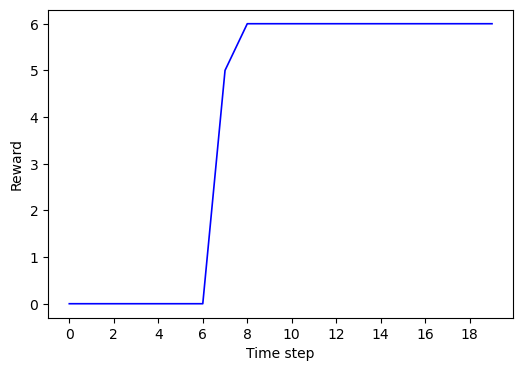

In [10]:
if not skip_training:
    plt.figure(figsize=(6, 4))
    plt.plot(rewards, linewidth=1.2, color='b')
    plt.xticks(list(range(0, len(rewards), 2)))
    plt.xlabel('Time step', fontsize=10)
    plt.ylabel('Reward', fontsize=10)
    plt.show()

<a id='Q1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1</b> Changing Number of Samples (5 points)</h3> 

<!-- Discuss the effect of changing the __number of samples__. How can this affect the performance and running time?             -->
Which statement is correct? Choose one option.
1. Increasing the number of samples (population) does not affect the performance, but it adds computational complexity, increasing the running time.
2. Increasing the number of samples (population) enhances exploration and chance of finding the global optimum without any effect on the running time.
3. Increasing the number of samples (population) enhances exploration and chance of finding the global optimum, but it requires more computation and it increases the running time consequently. However, parallel computing can be used to deal with extra computations.
4. Increasing the number of samples (population) enhances exploration and chance of finding global optimum, but it requires more computation and running time, parallel computing cannot be used to accelerate computations.
5. Increasing the number of samples (population) does not affect performance and running time.

🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

In [14]:
sq1 = 3  # type: int  # replace ``None`` with your choice

Do not remove or modify the following cells, which are used for grading.

<a id='Q2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.2</b> Model-free vs Mode-based RL (20 points)</h3> 

<!-- Assume that the dynamics model $s_{t+1} = f(s_t, a_t)$ (when using a probabilistic dynamics model $P(s_{t+1}| s_t, a_t)$) and reward model $R(s_t, a_t)$ are learned from data during training. CEM with learned models can be used to solve similar tasks as model-free reinforcement learning methods such as DDPG.
<br>
In what kind of tasks do you expect CEM with learned models to work better than DDPG? In which kind of tasks do you expect DDPG to work better than CEM with learned models in terms of performance and training time? Why?
<br>
Which parts of CEM with a learned dynamics model need to be taken into account when considering computation time and why? -->
Assume that the dynamics model $s_{t+1} = f(s_t, a_t)$ (when using a probabilistic dynamics model $P(s_{t+1}| s_t, a_t)$) and reward model $R(s_t, a_t)$ are learned from data during training. CEM with learned models can be used to solve similar tasks as model-free reinforcement learning methods such as DDPG.
Select all correct statements, you can select 4 options at maximum.

1. Generally speaking, CEM with learned models is more sample efficient than model-free methods like DDPG. CEM with learned models also requires approximately the same amount of computation in deployment compared to model-free methods.
2. Model-free methods like DDPG are better suited for tasks with high dimensional observations (e.g. images) compared to CEM with learned models.
3. In CEM with learned models, increasing the planning horizon always improves the performance given enough computations and time. 
4. Model-free methods like DDPG are better suited for deployment in real-time in applications with high frequency and limited hardware compared to CEM with learned models.
5. Model-free methods like DDPG are better suited for tasks with complex non-smooth dynamics (e.g. high number of contacts) compared to CEM with learned models. 
6. When planning with learned models in CEM, it is possible to exploit the inaccuracies in the models, especially over longer horizons.
7. Model-free methods like DDPG always converge to the optimal policy given enough samples, computation and time, but CEM with a learned model can converge to local optimum. 
8. Only neural networks are used to approximate the models based on data in CEM.
9. Generally speaking, model-free methods like DDPG are robust to hyper-parameters while CEM with learned models require careful selection of hyper-parameters.

    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

In [15]:
sq1_2 = [2, 4, 5, 9]  # write your options in the list

Do not remove or change the following cells, which are used for grading.

# 3. Submitting <a id='3.'></a>
Ensure all tasks and questions (in ```ex7_MCTS.ipynb```) are answered and the relevant plots are recorded in the relevant places. 

In [17]:
# Make sure that skip training is set to True before submission
assert skip_training == True

## 3.1 Feedback <a id='3.1'></a>

In order to help the staff of the course as well as the forthcoming students, it would be great if you could answer to the following questions in your submission:

1) How much time did you spend solving this exercise? (change the ```hrs``` variable below to a floating point number representing the number of hours taken e.g. 5.43)


In [ ]:
hrs = 2

2) Difficulty of each task/question from 1-5 (int or float)

In [18]:
T1 = 4 # Student Task 1. Implementing CEM
Q1 = 2 # Question 1.1: Number of samples
Q2 = 4 # Question 2.1: Model-free vs Model-based

3) How well did you understand the content of the task/question from 1-5? (int or float)


In [19]:
T1 = 3 # Student Task 1. Implementing CEM
Q1 = 5 # Question 1.1: Number of samples
Q2 = 3 # Question 2.1: Model-free vs Model-based

4) General feedback. Consider questions like:

    - Did the content of the lecture relate well with the assignment?
    - To what extent did you find the material to be potentially useful for your research and studies?
    
And other feedback you think is worth including. Type in the box below

Please use the following section to record references.
# References <a id='4.'></a>

